## 8. Pariwise Similarity Distribution 업데이트_기존 사용 코드 업데이트
- 데이터 normalize : 유사도 점수 정규화(같은 클래스 및 다른 클래스 간의 유사도 점수를 정규화합니다.)
- 각 모델별 x축 범위 통일
- 'torchvision'의 사전 학습된 모델 사용하여 임베딩 벡터 추출
- ImageNet 데이터셋에서 학습된 모델들, 기본적으로 일반적인 이미지 분류에 적합.
- 'torchvision'모델에서 임베딩을 추출하기 위해 모델의 특정 레이어 사용 ex. 'avgpool'레이어 사용해 임베딩 추출

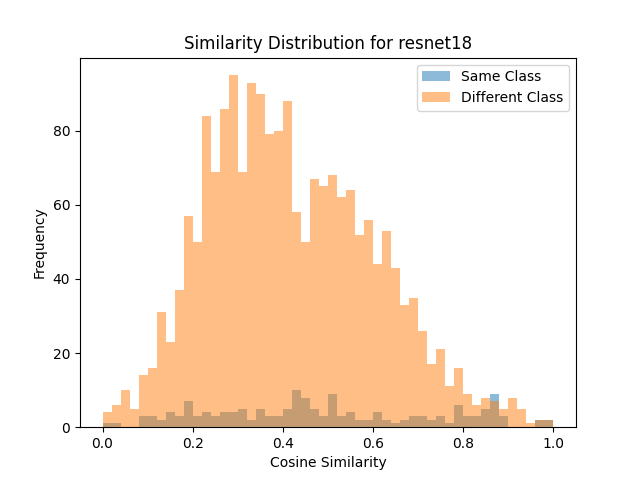
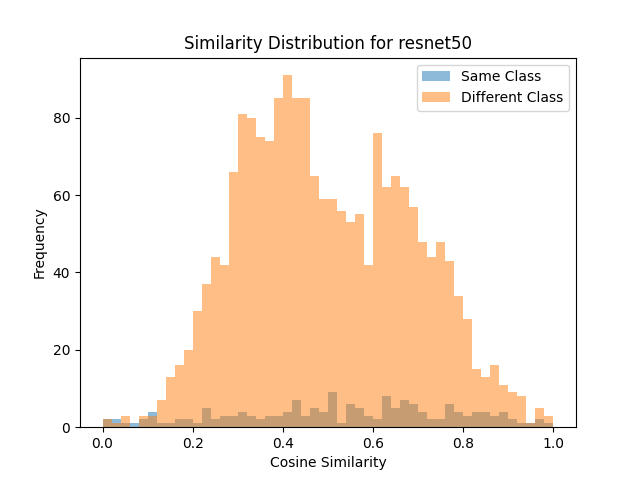
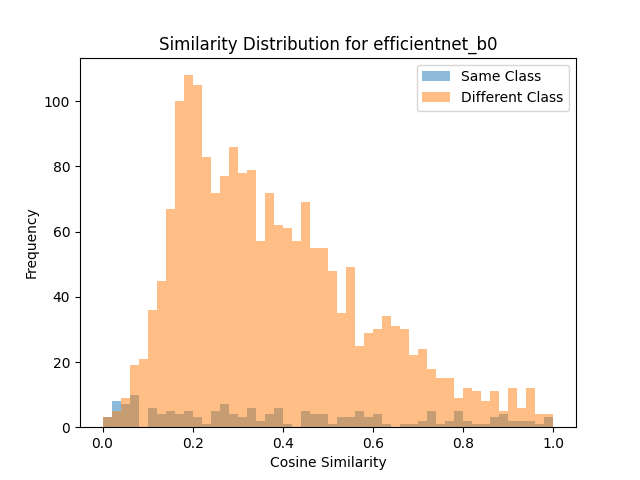
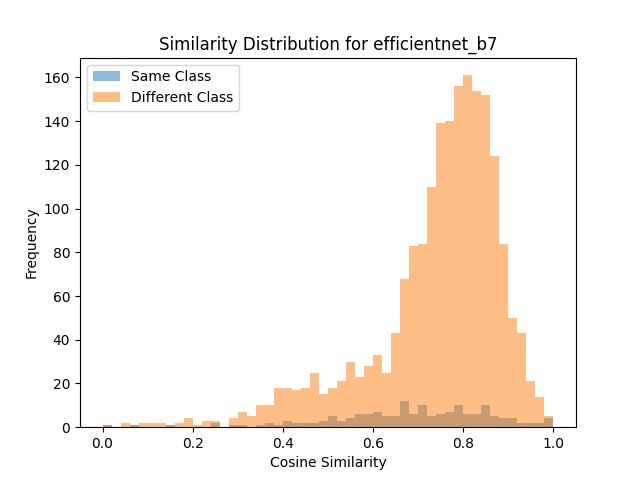

In [ ]:
##Programmer : Hyeon Ji Ha
##Date : Jun 10 2024
##Purpose : 8. Pairwise Similarity Distribution 방법 업데이트
##          data normalization + x축 범위 통일


import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl
import matplotlib.pyplot as plt

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 -> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

# Pairwise Similarity Distribution 계산
def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

# Normalize the similarity scores
def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

# 히스토그램 그리기
def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

def classify_images(model_names, folder_path, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # Pairwise Similarity Distribution 계산
        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)

        # Normalize the similarity scores
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        # 히스토그램 그리기 (통일된 X축 범위)
        x_range = (0, 1)
        plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


## OmniVec, Resnet18, Resnet50, vit_b_16 모델 사용.
- 모델을 사전에 학습된 모델을 로드한 후 사용.
- 'transformers' 라이브러리 사용하여 특정한 모델(ViTModel) 로드 or 특정한 경로에서 로드한 모델 사용.
- 모델의 마지막 레이어 or 특정한 레이어에서 임베딩 추출

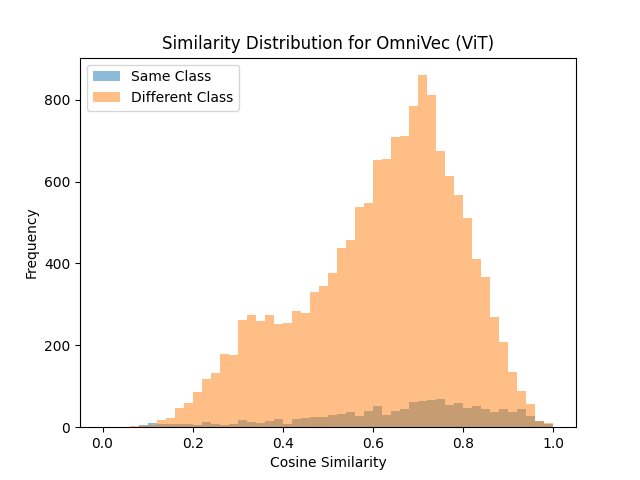 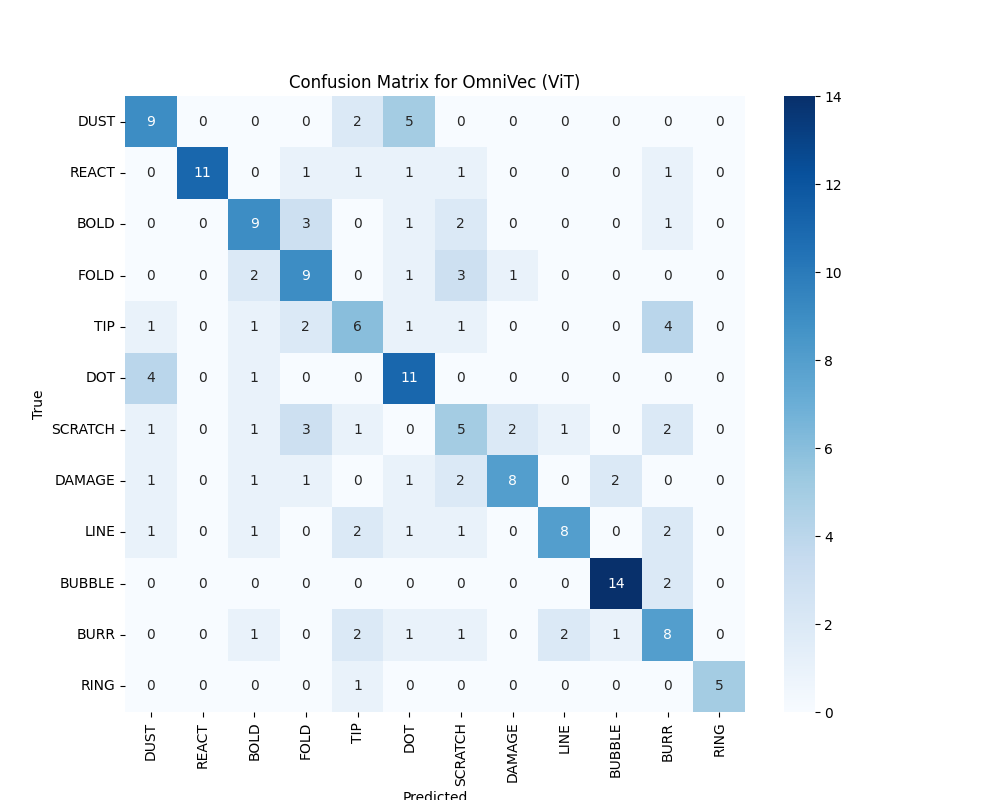 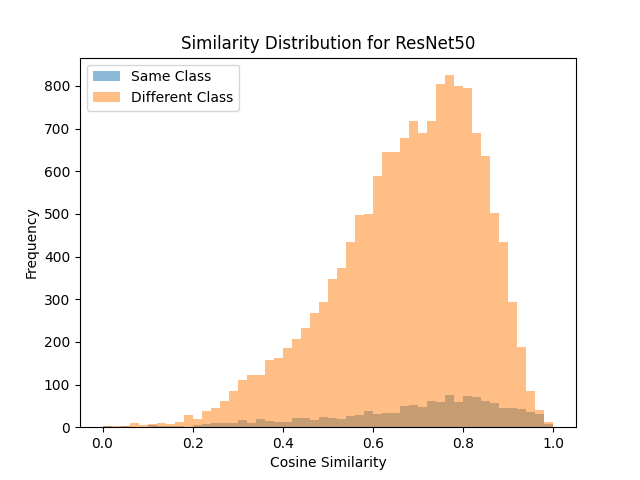 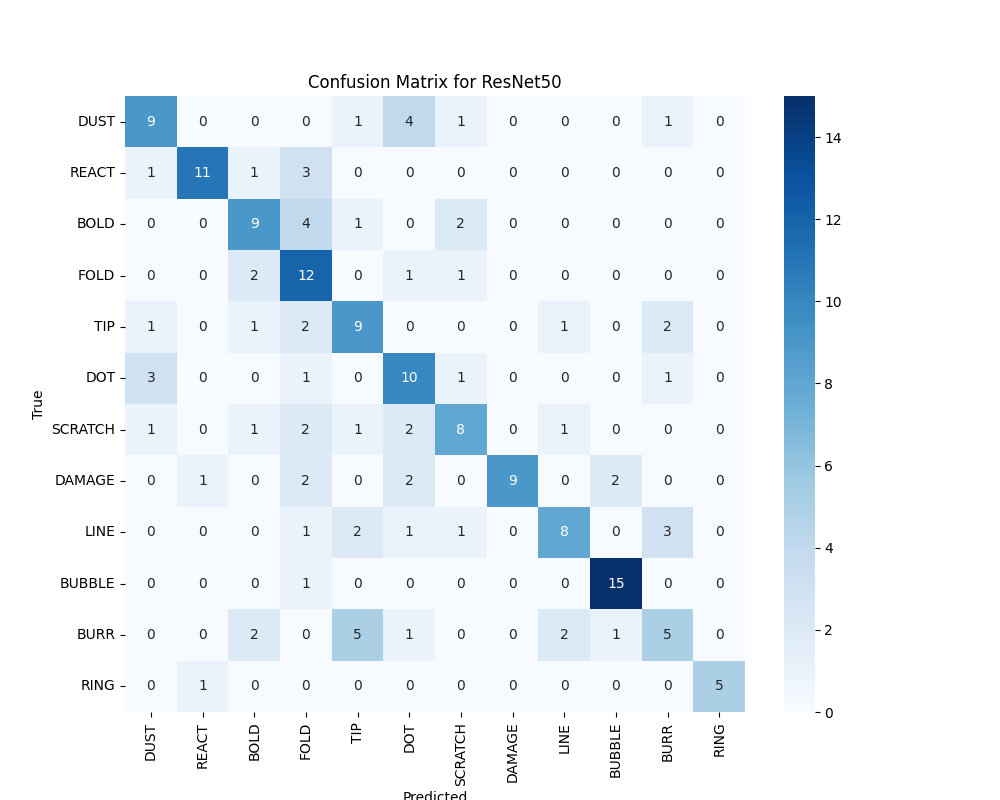 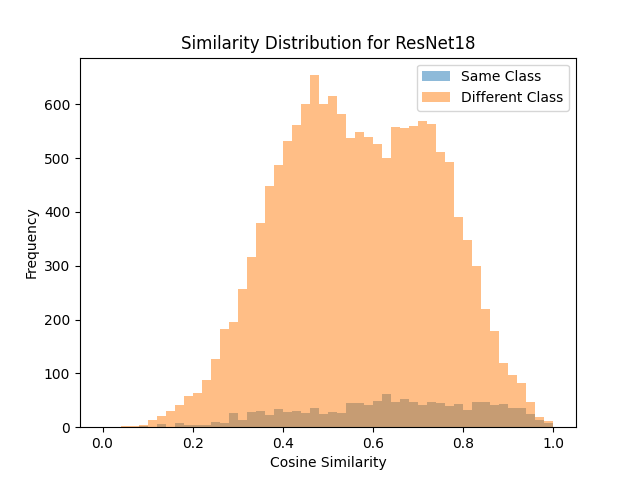 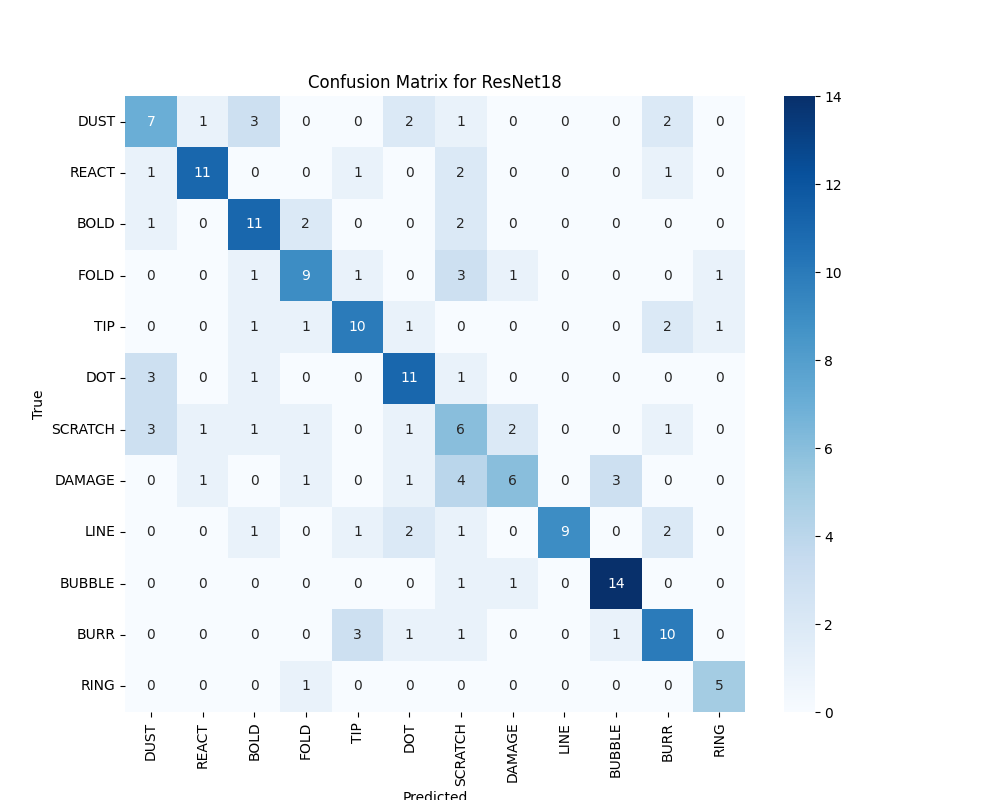

1. OmniVec (ViT)
- Similarity Distribution
  - 동일한 클래스(Same Class)의 코사인 유사도 값이 대체로 높은 편.
  - 다른 클래스(Different Class)의 유사도 값은 넓게 분포되어 있음.
  - 많은 샘플들이 유사도가 0.6에서 0.8 사이에 분포.
- Confusion Matrix
  - DUST, REACT, FOLD, DOT, BUBBLE 클래스에서 상대적으로 높은 정확도를 보임.
  - BOLD, TIP, SCRATCH 클래스에서는 예측이 상대적으로 혼란스러움.
  - 일부 클래스는 다른 클래스와 혼동됨. 예를 들어, TIP 클래스는 DUST 클래스와 혼동됨.

1. ResNet50
- Similarity Distribution
  - 동일한 클래스의 유사도 값이 높게 나타남.
  - 다른 클래스의 유사도 값은 넓게 분포됨.
  - 유사도 값이 대체로 0.6에서 0.8 사이에 분포.
- Confusion Matrix
  - DUST, REACT, BUBBLE, DOT, FOLD 클래스에서 높은 정확도.
  - BOLD, TIP, SCRATCH 클래스에서 예측이 상대적으로 어렵게 나타남.
  - TIP 클래스는 BOLD 클래스와 혼동됨.
  
1. ResNet18
- Similarity Distribution
  - 동일한 클래스의 유사도 값이 높게 나타남.
  - 다른 클래스의 유사도 값은 넓게 분포됨.
  - 많은 샘플들이 유사도가 0.4에서 0.6 사이에 분포.
- Confusion Matrix
  - DUST, REACT, BUBBLE, DOT 클래스에서 높은 정확도.
  - BOLD, TIP, SCRATCH, DAMAGE 클래스에서 예측이 어려움.
  - SCRATCH 클래스는 TIP 클래스와 혼동됨.
  - 
### 종합 분석
- OmniVec (ViT) 모델은 동일한 클래스의 이미지들을 잘 구별하며, 다른 클래스와의 유사도가 상대적으로 낮음. 하지만 일부 클래스는 여전히 혼동됨.
- ResNet50 모델은 OmniVec (ViT) 모델보다 전반적으로 예측 성능이 우수함. 특히 DUST, REACT, BUBBLE 클래스에서 뛰어난 성능을 보임.
- ResNet18 모델은 전반적으로 다른 모델들에 비해 성능이 떨어지며, 특정 클래스 간의 혼동이 많이 발생함.



In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import time
import os
import ssl
import matplotlib.pyplot as plt
import seaborn as sns

# SSL 인증서 설정
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 임베딩 벡터 생성 클래스 (모델명에 따라 변환)
class Img2Vec():
    def __init__(self, model, model_name, cuda=False):
        self.model = model
        self.model_name = model_name
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image).squeeze().cpu().numpy()
        return embedding

# 주어진 폴더에서 이미지와 레이블 로드
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

# Pairwise Similarity Distribution 계산
def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

# Normalize the similarity scores
def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

# 히스토그램 그리기
def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

# Confusion Matrix 계산 및 플롯
def plot_confusion_matrix(true_labels, pred_labels, model_name, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def classify_images(model_dict, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    for model_name, model in model_dict.items():
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(model, model_name, cuda=cuda)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        x_range = (0, 1)
        plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range)

        # Confusion Matrix 계산
        predicted_labels = []
        for emb in embeddings:
            sims = cosine_similarity([emb], embeddings)[0]
            sims = [(s, labels[idx]) for idx, s in enumerate(sims)]
            sims = sorted(sims, key=lambda x: x[0], reverse=True)
            top_label = sims[1][1]  # 가장 유사한 (자기 자신을 제외한) 이미지의 레이블 선택
            predicted_labels.append(top_label)
        
        plot_confusion_matrix(labels, predicted_labels, model_name, list(set(labels)))

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    from torchvision import models as torchvision_models

    # 새로운 모델 불러오기 (임의의 예시, 실제 모델 불러오기 코드 필요)
    model_dict = {
        'OmniVec (ViT)': torchvision_models.vit_b_16(pretrained=True),
        'ResNet50': torchvision_models.resnet50(pretrained=True),  #  resnet50 사용. resnet50
        'ResNet18': torchvision_models.resnet18(pretrained=True),      #  resnet18 사용. resnet18
        #'Model soups (ViT-G/14)': torchvision_models.vit_b_16(pretrained=True)      # 임의로 vit_b_16 사용. vit_b_16
    }

    cuda = torch.cuda.is_available()

    results = classify_images(model_dict, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


### CoCa 추가
- 코드에선 임의로 clip 모델 사용
- CoCa 모델 관련 코드 따로 구현해서 추가하기 ***

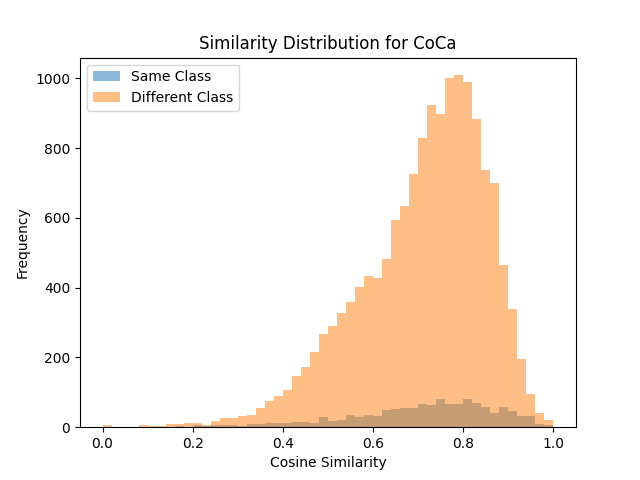 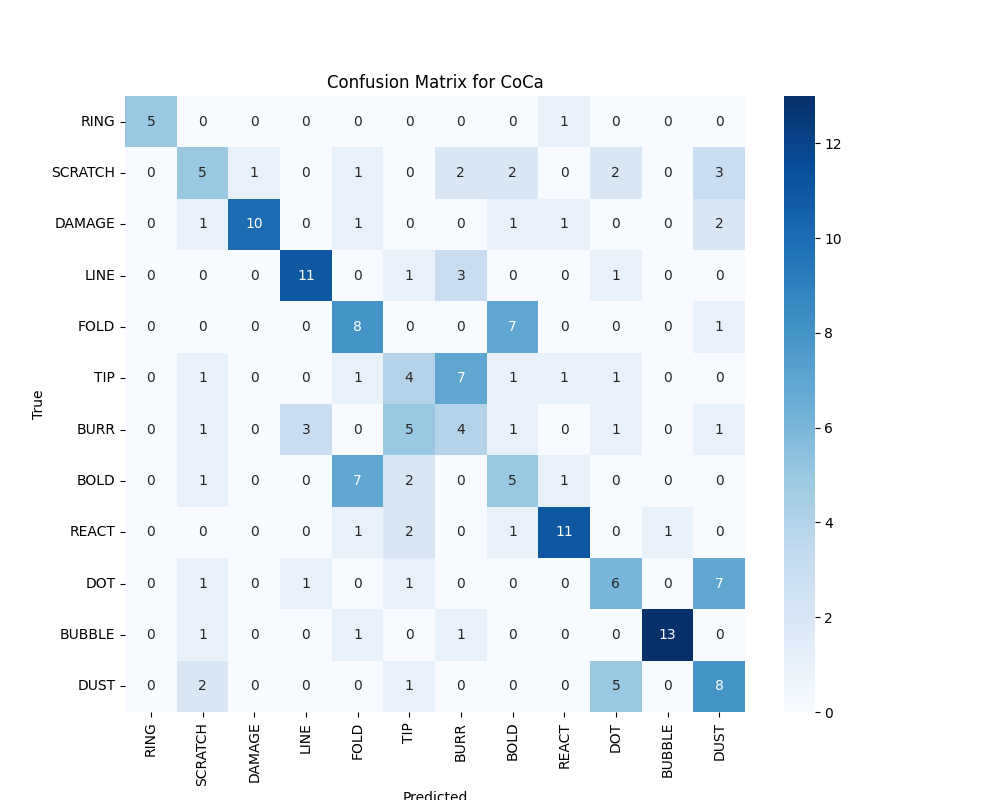

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import time
import os
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel

# SSL 인증서 설정
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# CoCa 모델 임베딩 벡터 생성 클래스
class CoCaImg2Vec():
    def __init__(self, model_name, cuda=False):
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_vec(self, img):
        inputs = self.processor(images=img, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model.get_image_features(**inputs).cpu().numpy()
        return outputs.flatten()

# 기존 임베딩 벡터 생성 클래스 (모델명에 따라 변환)
class Img2Vec():
    def __init__(self, model, model_name, cuda=False):
        self.model = model
        self.model_name = model_name
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image).squeeze().cpu().numpy()
        return embedding

# 주어진 폴더에서 이미지와 레이블 로드
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

# Pairwise Similarity Distribution 계산
def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

# Normalize the similarity scores
def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

# 히스토그램 그리기
def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

# Confusion Matrix 계산 및 플롯
def plot_confusion_matrix(true_labels, pred_labels, model_name, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def classify_images(model_dict, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    for model_name, model in model_dict.items():
        print(f"Evaluating model {model_name}")
        if model_name == "CoCa":
            img2vec = CoCaImg2Vec(model, cuda=cuda)
        else:
            img2vec = Img2Vec(model, model_name, cuda=cuda)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        x_range = (0, 1)
        plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range)

        # Confusion Matrix 계산
        predicted_labels = []
        for emb in embeddings:
            sims = cosine_similarity([emb], embeddings)[0]
            sims = [(s, labels[idx]) for idx, s in enumerate(sims)]
            sims = sorted(sims, key=lambda x: x[0], reverse=True)
            top_label = sims[1][1]  # 가장 유사한 (자기 자신을 제외한) 이미지의 레이블 선택
            predicted_labels.append(top_label)
        
        plot_confusion_matrix(labels, predicted_labels, model_name, list(set(labels)))

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    from torchvision import models as torchvision_models

    # 새로운 모델 불러오기 (임의의 예시, 실제 모델 불러오기 코드 필요)
    model_dict = {
       # 'OmniVec (ViT)': torchvision_models.vit_b_16(pretrained=True),
       # 'ResNet50': torchvision_models.resnet50(pretrained=True),
       # 'ResNet18': torchvision_models.resnet18(pretrained=True),
        'CoCa': "openai/clip-vit-base-patch32"  # CoCa 모델 추가
    }

    cuda = torch.cuda.is_available()

    results = classify_images(model_dict, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")
